<a href="https://colab.research.google.com/github/Davidsonity/Traffic_Sign_Classifier/blob/main/Notebook/Traffic_Sign_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Traffic Sign Classification**



In [ ]:
# Select the kaggle.json file downloaded frm kaggle account settting page
from google.colab import files
files.upload()

In [2]:
# Installing Kaggle API client
!pip install -q kaggle

In [3]:
# creating /.kaggle because the kaggle API client expect the file to be in this format so we move it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# This permissons changes avoid a warning on kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Creating directory and changing the current working directory
!mkdir traffic_sign_dataset
%cd traffic_sign_dataset

/content/traffic_sign_dataset


In [5]:
# search for dataset
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 612M/612M [00:02<00:00, 319MB/s]
100% 612M/612M [00:02<00:00, 300MB/s]


In [ ]:
# unzipping downloaded dataset
!unzip gtsrb-german-traffic-sign.zip
!rm gtsrb-german-traffic-sign.zip

In [60]:
# removing unwanted file
!rm -rf /content/traffic_sign_dataset/Meta
!rm -rf /content/traffic_sign_dataset/meta
!rm -rf /content/traffic_sign_dataset/test
!rm -rf /content/traffic_sign_dataset/train
!rm -rf /content/traffic_sign_dataset/Meta.csv
!rm /content/traffic_sign_dataset/Test/GT-final_test.csv

In [18]:
# Important library imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from tqdm import tqdm
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop

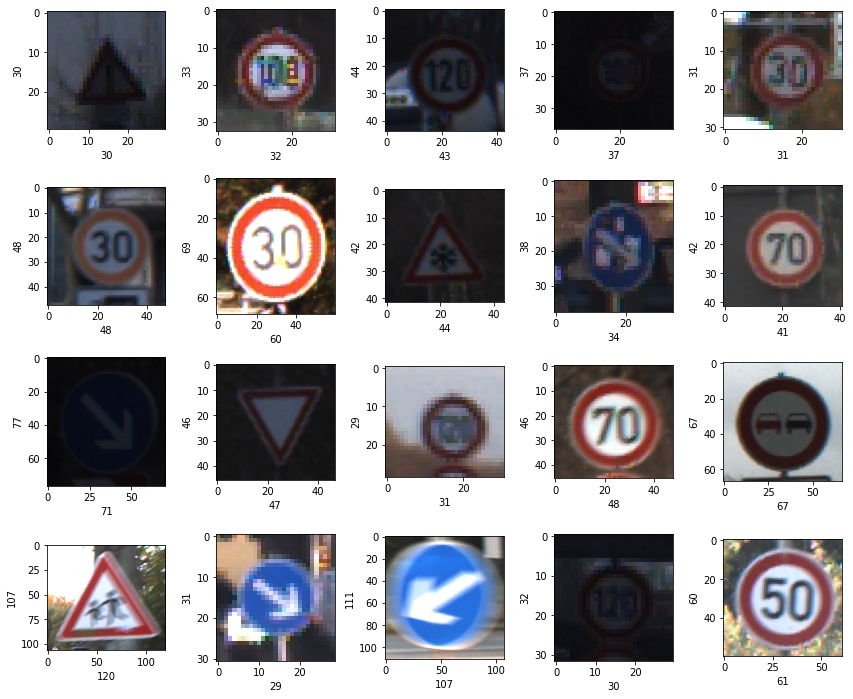

In [29]:
# Visualizing random images in dataset
plt.figure(figsize=(12, 12))
path = '/content/traffic_sign_dataset/Test'
for i in range(1, 21):
  plt.subplot(5, 5, i)
  plt.tight_layout()
  rand_img = plt.imread(path + '/' + random.choice(sorted(os.listdir(path))))
  plt.imshow(rand_img)
  # Plotting Dimensions of images
  plt.xlabel(rand_img.shape[1], fontsize=10)
  plt.ylabel(rand_img.shape[0], fontsize=10)

In [30]:
# The images have different sizes so we have to make them equal so we will take the mean of the various dimensions
dim_y = []
dim_x = []

for i in range(0, 43):
  labels = '/content/traffic_sign_dataset/Train/{}'.format(i)
  image_path = os.listdir(labels)
  for x in image_path:
    img = plt.imread(labels + '/' + x)
    dim_y.append(img.shape[0])
    dim_x.append(img.shape[1])

In [31]:
# Printing mean dimension of images
print('Y Dimenison Mean:', np.mean(dim_y))
print('X Dimenison Mean:', np.mean(dim_x))

Y Dimenison Mean: 50.328929582493814
X Dimenison Mean: 50.83587951745773


Here we can see that 50 x 50 is the average size of all images

In [33]:
# Now we will rehape the images to (50, 50)
images = []
labels_id = []
for i in range(43):
  labels = '/content/traffic_sign_dataset/Train/{}'.format(i)
  image_path = os.listdir(labels)
  for x in image_path:
    img = Image.open(labels + '/' + x)
    img = img.resize((50, 50))
    img = np.array(img)
    images.append(img)
    labels_id.append(i)

In [34]:
# Convering images into mupy array
images = np.array(images)
# Normalizing images
images = images / 255

In [36]:
# Storing labels into numpy array
labels_id = np.array(labels_id)
labels_id.shape

(39209,)

In [37]:
# Cheecking the shape of images
images.shape

(39209, 50, 50, 3)

In [41]:
# Now we check if data is balanced or imbalanced by visualizing the number of classes count
label_df = pd.DataFrame(labels_id)
label_df.value_counts().head()

2     2250
1     2220
13    2160
12    2100
38    2070
dtype: int64

In [45]:
# Next we split the data into training and validation set
x_train, x_val, y_train, y_val = train_test_split(images, labels_id, test_size= 0.2, random_state= 42)

In [46]:
# Converting the classes column to categorical using to_categorical() function
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

dtype('int64')

# **Building Model**

In [55]:
i = Input(shape = x_train[0].shape)
x = Conv2D(64, (3,3), activation= 'relu', padding= 'same')(i)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3,3), activation= 'relu', padding= 'same')(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.2)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(43, activation= 'softmax')(x)

model = Model(i, x)

In [56]:
model.compile(optimizer= Adam(0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 50, 64)        1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 25, 25, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 25, 25, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                       

In [57]:
batch_size = 128
steps_per_epoch = x_train.shape[0]//batch_size
r = model.fit(x_train, y_train, batch_size = batch_size,
              epochs = 10,
              validation_data = (x_val, y_val),
              steps_per_epoch = steps_per_epoch,
              verbose= 2)

Epoch 1/10
245/245 - 17s - loss: 1.6667 - accuracy: 0.5381 - val_loss: 0.4748 - val_accuracy: 0.8780 - 17s/epoch - 71ms/step
Epoch 2/10
245/245 - 5s - loss: 0.4063 - accuracy: 0.8764 - val_loss: 0.1625 - val_accuracy: 0.9643 - 5s/epoch - 19ms/step
Epoch 3/10
245/245 - 5s - loss: 0.2211 - accuracy: 0.9346 - val_loss: 0.1145 - val_accuracy: 0.9727 - 5s/epoch - 19ms/step
Epoch 4/10
245/245 - 5s - loss: 0.1633 - accuracy: 0.9505 - val_loss: 0.0811 - val_accuracy: 0.9804 - 5s/epoch - 19ms/step
Epoch 5/10
245/245 - 5s - loss: 0.1130 - accuracy: 0.9663 - val_loss: 0.0619 - val_accuracy: 0.9843 - 5s/epoch - 19ms/step
Epoch 6/10
245/245 - 5s - loss: 0.0884 - accuracy: 0.9731 - val_loss: 0.0594 - val_accuracy: 0.9862 - 5s/epoch - 19ms/step
Epoch 7/10
245/245 - 5s - loss: 0.0804 - accuracy: 0.9755 - val_loss: 0.0485 - val_accuracy: 0.9884 - 5s/epoch - 19ms/step
Epoch 8/10
245/245 - 5s - loss: 0.0631 - accuracy: 0.9800 - val_loss: 0.0433 - val_accuracy: 0.9902 - 5s/epoch - 19ms/step
Epoch 9/10
245

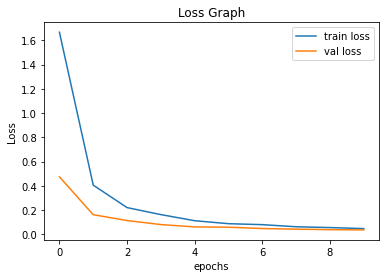

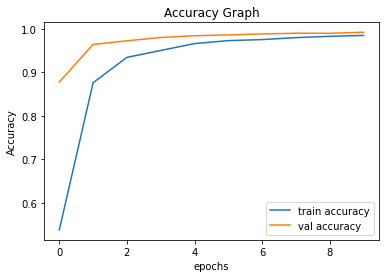

In [139]:
# Plot loss per iteration
plt.plot(r.history['loss'], label= 'train loss')
plt.plot(r.history['val_loss'], label= 'val loss')
plt.title("Loss Graph")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot accouracy per iteration
plt.plot(r.history['accuracy'], label= 'train accuracy')
plt.plot(r.history['val_accuracy'], label= 'val accuracy')
plt.title("Accuracy Graph")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [76]:
test_path = '/content/traffic_sign_dataset/Test'

In [79]:
# Now we scale the testing image by defining a function to scale the image
def Scaling(test_images, test_path):
  images = []
  image_path = test_images

  for x in image_path:
    img = Image.open(test_path + '/' + x)
    img = img.resize((50, 50))
    img = np.array(img)
    images.append(img)
  
  # Convert images into numpy array
  images = np.array(images)
  # Normalizing images
  images = images / 255

  return images

In [80]:
# Calling the function
test_images = Scaling(sorted(os.listdir(test_path)), test_path)

In [ ]:
# Next we read labels id
test = pd.read_csv('/content/traffic_sign_dataset/Test.csv')
test

In [82]:
y_test = test['ClassId'].values
y_test

array([16,  1, 38, ...,  6,  7, 10])

In [95]:
# testing model with test dataset
y_pred = np.argmax(model.predict(test_images), axis=-1)
y_pred

array([16,  1, 38, ..., 38,  7, 10])

In [109]:
path_list = os.listdir(test_path)

Original label: 7
Predicted label: 7


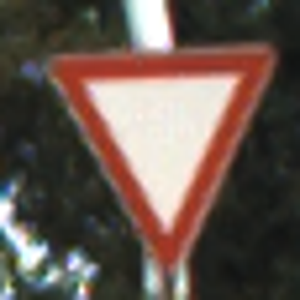

In [133]:
# Visualize test image
x = random.choice(range(1, len(path_list)+1))

img = Image.open(test_path + '/' + path_list[x])
img = img.resize((300, 300))

# Original classID
print("Original label:", y_test[x])

# Predicted label
print("Predicted label:", y_pred[x])
img

In [134]:
from sklearn.metrics import accuracy_score
print("accuracy: ", accuracy_score(y_test, y_pred))

accuracy:  0.942596991290578


In [140]:
model.save('traffic_signal_classifier.h5')

## **CONCLUSION:**


> Model reached a validation accuracy of 98%+. It also got an accuracy of 94%+ on new unseen test dataset.  
